In [15]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [18]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [19]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [20]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [21]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23',)

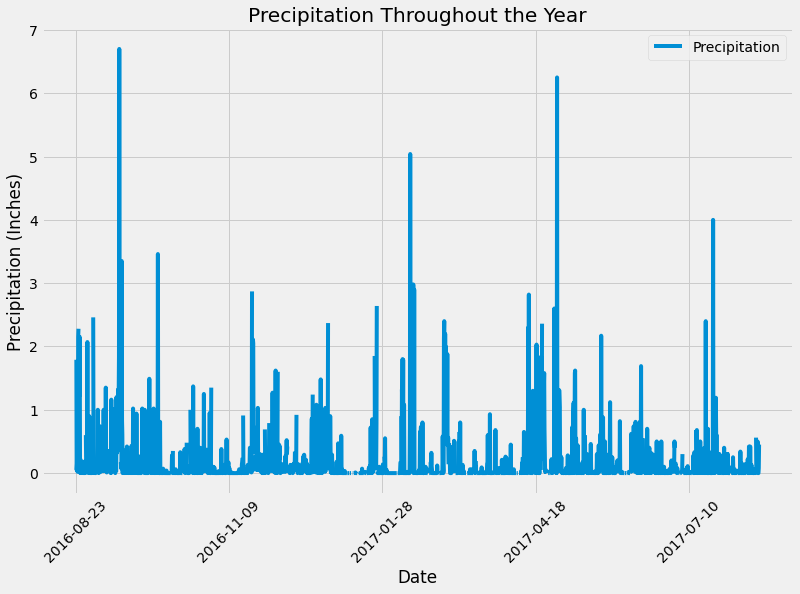

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = dt.date(2017,8, 23)

# Calculate the date one year from the last date in data set.
year_ago =  latest_date - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
#measurement_df = pd.DataFrame(query).rename(columns = {'prcp': 'precipitation'})

measurement_df = pd.DataFrame(query, columns=['Date', 'Precipitation'])
measurement_df.set_index('Date', inplace=True)


# Sort the dataframe by date
sorted_measurement_df = measurement_df.sort_index()


# Use Pandas Plotting with Matplotlib to plot the data
sorted_measurement_df.plot(rot=45, figsize=(12,8))
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.title('Precipitation Throughout the Year')
plt.show()



In [37]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_measurement_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [38]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [39]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station_lst = [Measurement.station, func.count(Measurement.station)]

active_station = session.query(*active_station_lst).group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).first().station

session.query(*active_station_lst).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [41]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_lst = [Measurement.station,
           func.min(Measurement.tobs),
           func.max(Measurement.tobs),
           func.avg(Measurement.tobs)]

query = session.query(*temp_lst).group_by(Measurement.station).filter(Measurement.station == active_station).all()

print(f"The most active station id is {query[0][0]}.")
print(f"The lowest temperature is {query[0][1]}.")
print(f"The highest temperature is {query[0][2]}.")
print(f"The average temperature is {query[0][3]}.")

The most active station id is USC00519281.
The lowest temperature is 54.0.
The highest temperature is 85.0.
The average temperature is 71.66378066378067.


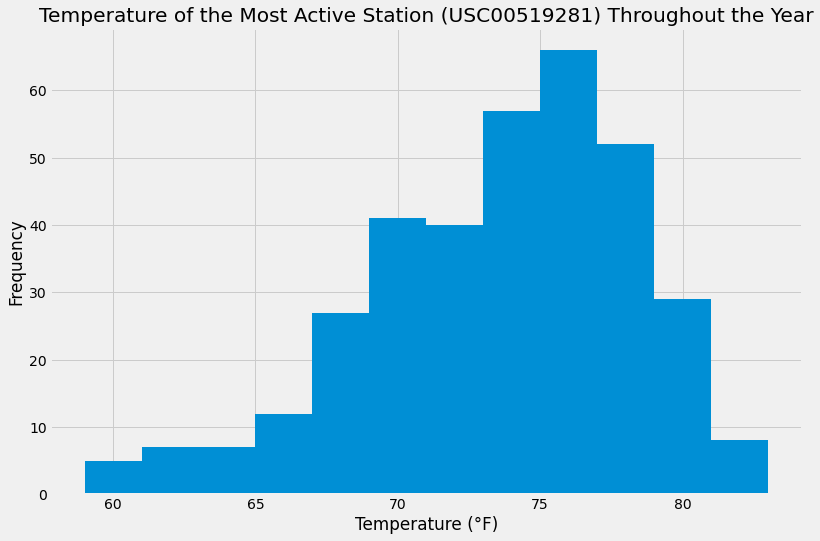

In [44]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_temp = session.query(Measurement.station, Measurement.tobs).\
filter(func.strftime('%Y-%m-%d', Measurement.date) > year_ago).filter(Measurement.station == active_station).all()
active_station_temp_df = pd.DataFrame(active_station_temp, columns=['Station', 'Temperature'])

active_station_temp_df.hist(bins=12, figsize=(12, 8))
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature of the Most Active Station ({active_station_temp[0][0]}) Throughout the Year')
plt.show()

# Close session

In [ ]:
# Close Session
session.close()